<a href="https://colab.research.google.com/github/chumdan/Machine-Learning-Project/blob/main/Machine%20Learning%20Project/Regression/%EB%AC%B8%EC%A0%9C9_%EC%83%88%EB%A1%9C%EC%B6%9C%EC%8B%9C%EB%90%9C_%EA%B2%8C%EC%9E%84%2C_%EC%A0%84%EB%AC%B8%EA%B0%80_%EB%A6%AC%EB%B7%B0_%EC%8B%A0%EB%A2%B0%EB%8F%84_%EC%B8%A1%EC%A0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : 게임, 전문가 리뷰 신뢰도 측정 (회귀문제유형)




### Step 0. 필요패키지 설치

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost import XGBClassifier as XGB
from lightgbm import LGBMClassifier as LGBM
from sklearn.feature_selection import *
from sklearn.metrics import f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.metrics import classification_report
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve

In [ ]:
# os.environ을 이용하여 Kaggle API Username, Key 세팅하기
os.environ['KAGGLE_USERNAME'] = 'chumdan'
os.environ['KAGGLE_KEY'] = '0e8bf51ba50bce898a8a9736072bd3b8'

In [ ]:
# Linux 명령어로 Kaggle API를 이용하여 데이터셋 다운로드하기 (!kaggle ~)
# Linux 명령어로 압축 해제하기
!rm *.*
!kaggle datasets download -d rush4ratio/video-game-sales-with-ratings
!unzip '*.zip'

rm: cannot remove '*.*': No such file or directory
  0% 0.00/476k [00:00<?, ?B/s]
100% 476k/476k [00:00<00:00, 71.2MB/s]
Archive:  video-game-sales-with-ratings.zip
  inflating: Video_Games_Sales_as_at_22_Dec_2016.csv  


### 데이터 소개
    Video Game Sales with Ratings을 사용
    - Video_Games_Sales_as_at_22_Dec_2016.csv

    Name: 게임의 이름
    Platform: 게임이 동작하는 콘솔
    Year_of_Release: 발매 년도
    Genre: 게임의 장르
    Publisher: 게임의 유통사
    NA_Sales: 북미 판매량 (Millions)
    EU_Sales: 유럽 연합 판매량 (Millions)
    JP_Sales: 일본 판매량 (Millions)
    Other_Sales: 기타 판매량 (아프리카, 일본 제외 아시아, 호주, EU 제외 유럽, 남미) (Millions)
    Global_Sales: 전국 판매량
    Critic_Score: Metacritic 스태프 점수
    Critic_Count: Critic_Score에 사용된 점수의 수
    User_Score: Metacritic 구독자의 점수
    User_Count: User_Score에 사용된 점수의 수
    Developer: 게임의 개발사
    Rating: ESRB 등급 (19+, 17+, 등등)

    종속변수 : 'Global_Sales' 세계 판매량
    
    
- 데이터 출처: https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings

In [ ]:
df = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')

In [ ]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


### Step 1. 데이터 기초 통계 분석 및 그래프

#### 결손 데이터 데이터프레임에서 제거

In [ ]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Developer          6623
Rating             6769
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16667,E.T. The Extra-Terrestrial,GBA,2001.0,Action,NewKidCo,0.01,0.00,0.00,0.00,0.01,46.0,4.0,2.4,21.0,Fluid Studios,E
16677,Mortal Kombat: Deadly Alliance,GBA,2002.0,Fighting,Midway Games,0.01,0.00,0.00,0.00,0.01,81.0,12.0,8.8,9.0,Criterion Games,M
16696,Metal Gear Solid V: Ground Zeroes,PC,2014.0,Action,Konami Digital Entertainment,0.00,0.01,0.00,0.00,0.01,80.0,20.0,7.6,412.0,Kojima Productions,M
16700,Breach,PC,2011.0,Shooter,Destineer,0.01,0.00,0.00,0.00,0.01,61.0,12.0,5.8,43.0,Atomic Games,T


#### 수치형 데이터의 히스토그램확인

In [ ]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

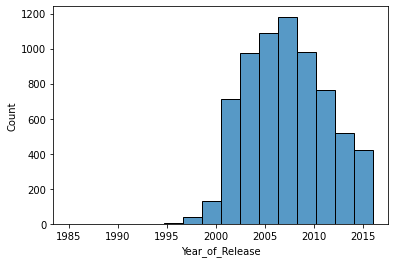

In [ ]:
sns.histplot(x='Year_of_Release', data=df, bins=16)

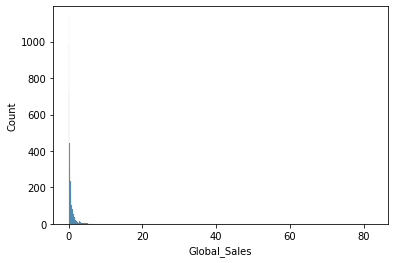

In [ ]:
# 아웃라이어가 큰.
sns.histplot(x='Global_Sales', data=df)

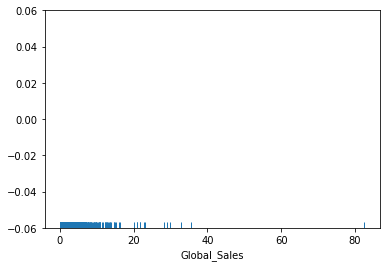

In [ ]:
sns.rugplot(x='Global_Sales', data=df)

In [ ]:
df[df['Global_Sales'] > 30]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E


In [ ]:
gs = df['Global_Sales'].quantile(0.99)

In [ ]:
df = df[df['Global_Sales'] < gs]

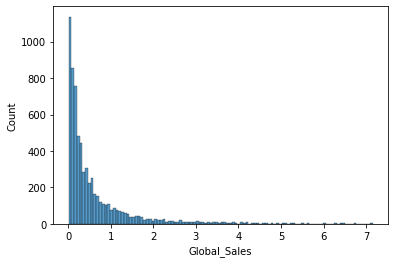

In [ ]:
sns.histplot(x='Global_Sales', data=df)

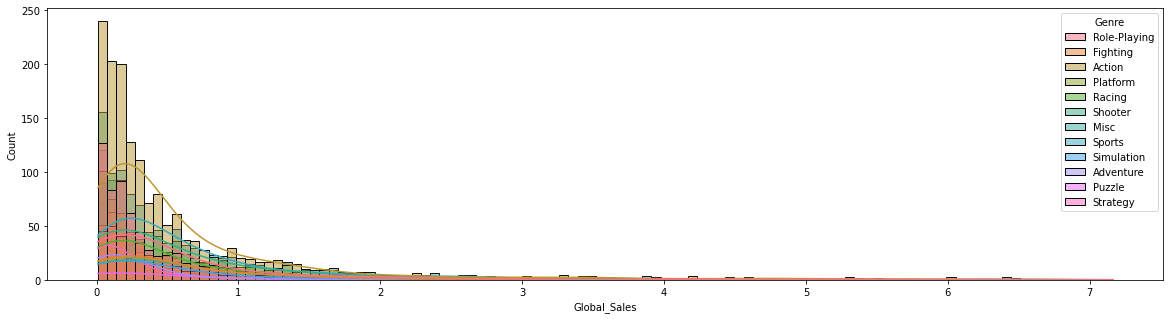

In [ ]:
fig = plt.figure(figsize=(20, 5))
sns.histplot(x='Global_Sales', hue='Genre', kde=True, data=df)

In [ ]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

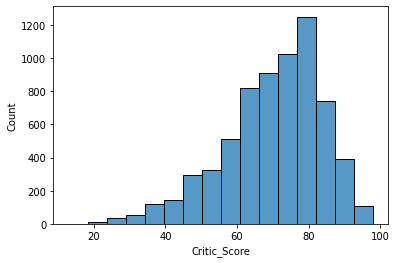

In [ ]:
sns.histplot(x='Critic_Score', data=df, bins=16)

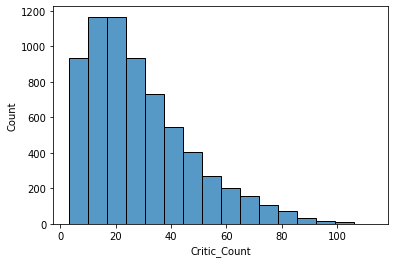

In [ ]:
sns.histplot(x='Critic_Count', data=df, bins=16)

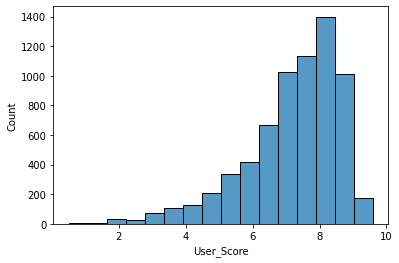

In [ ]:
sns.histplot(data=df['User_Score'].apply(float), bins=16)

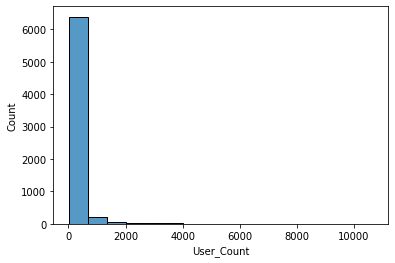

In [ ]:
sns.histplot(x='User_Count', data=df, bins=16)

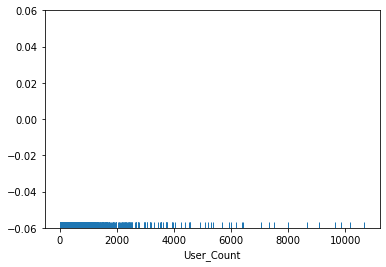

In [ ]:
sns.rugplot(x='User_Count', data=df)

In [ ]:
uc = df['User_Count'].quantile(0.99)

In [ ]:
df = df[df['User_Count'] < uc]

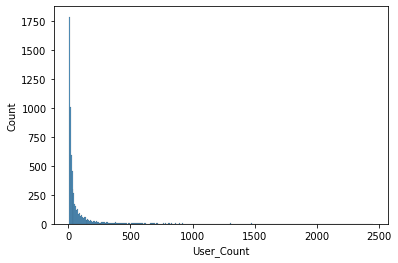

In [ ]:
sns.histplot(x='User_Count', data=df)

In [ ]:
uc = df['User_Count'].quantile(0.97)
print(uc)

911.5599999999977


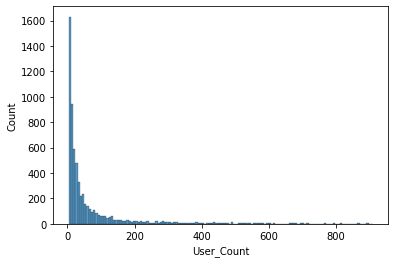

In [ ]:
df = df[df['User_Count'] < uc]
sns.histplot(x='User_Count', data=df)

#### 수치형 데이터와 전국 판매량 분석

In [ ]:
df['User_Score'] = df['User_Score'].apply(float)

In [ ]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

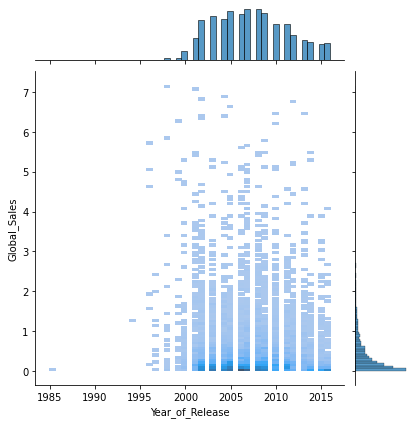

In [ ]:
sns.jointplot(x='Year_of_Release', y='Global_Sales', data=df, kind='hist')

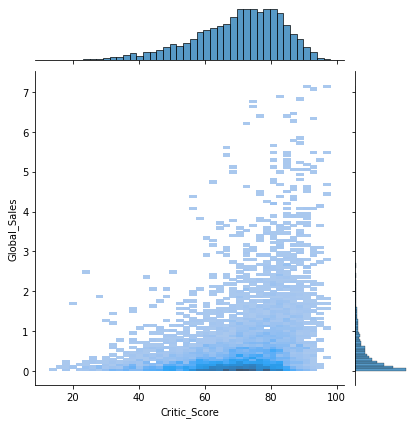

In [ ]:
sns.jointplot(x='Critic_Score', y='Global_Sales', data=df, kind='hist')

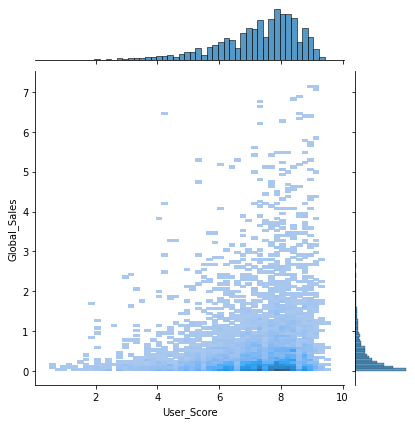

In [ ]:
sns.jointplot(x='User_Score', y='Global_Sales', data=df, kind='hist')

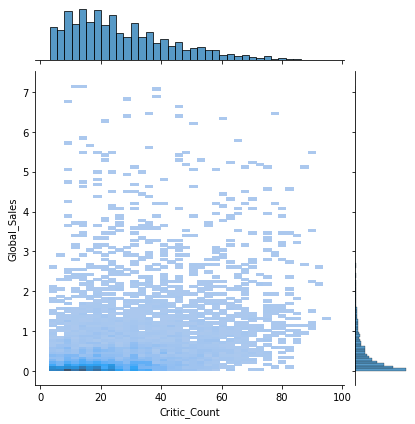

In [ ]:
sns.jointplot(x='Critic_Count', y='Global_Sales', data=df, kind='hist')

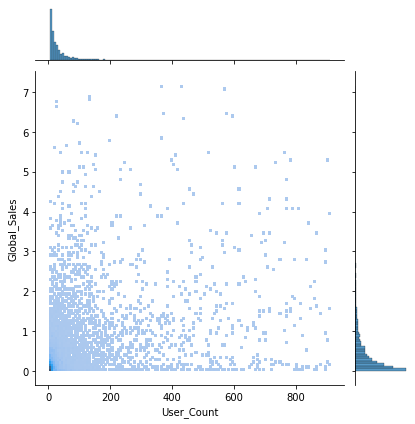

In [ ]:
sns.jointplot(x='User_Count', y='Global_Sales', data=df, kind='hist')
# Global_Sales 는 user_count, user_score와 연결이 깊음. 선후관계가 있어서, user_cpount와 user_score는 변수제거

#### 범주형 데이터의 범주별 전국 판매량의 Boxplot 분석

In [ ]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

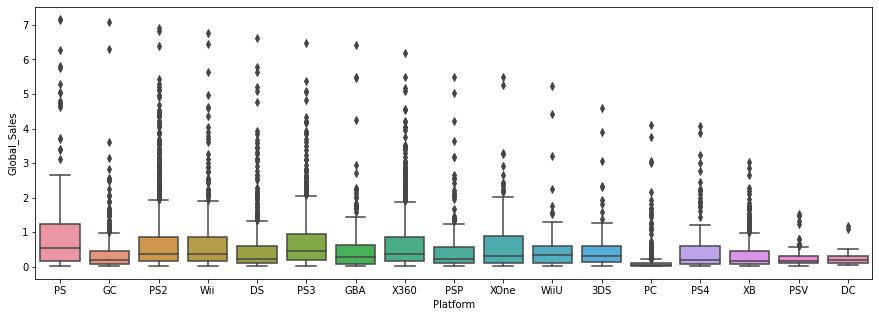

In [ ]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x='Platform', y='Global_Sales', data=df)

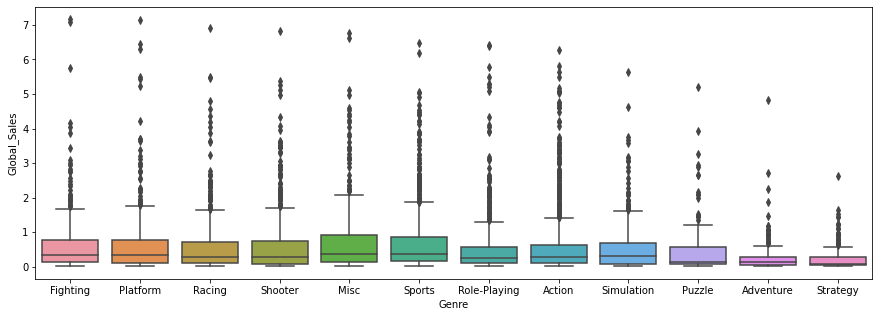

In [ ]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x='Genre', y='Global_Sales', data=df)

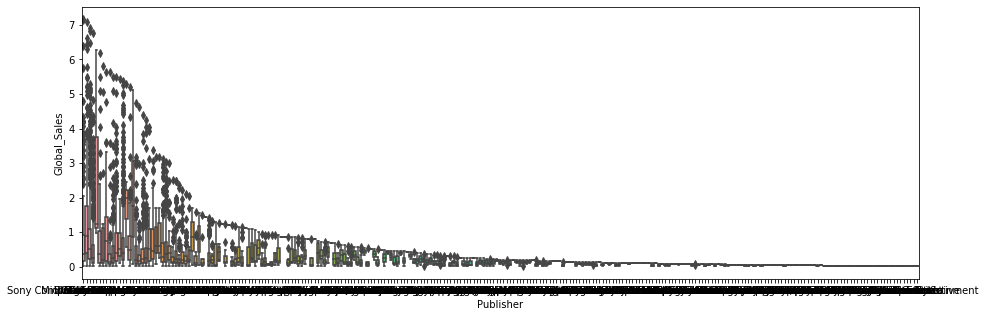

In [ ]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x='Publisher', y='Global_Sales', data=df)

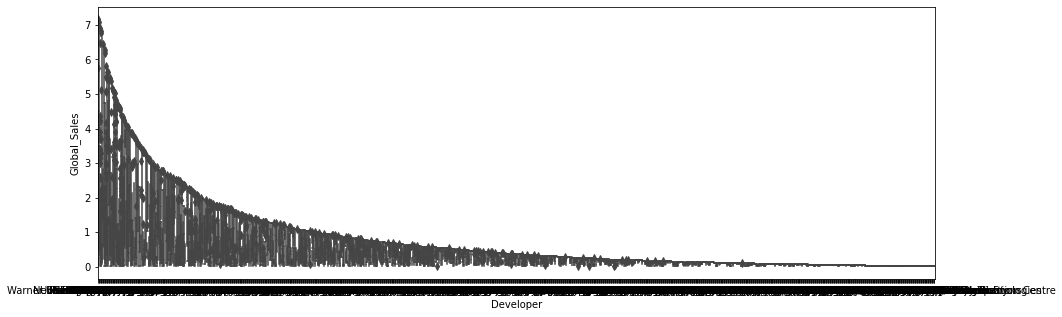

In [ ]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x='Developer', y='Global_Sales', data=df)

#### 전문가 평점과 사용자 평점의 차이 분석

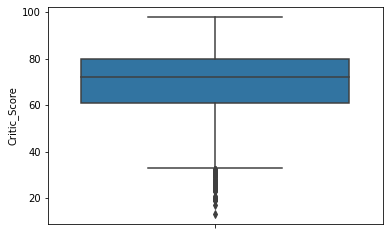

In [ ]:
sns.boxplot(y='Critic_Score', data=df)

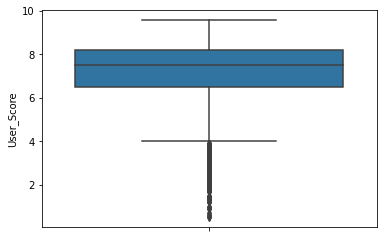

In [ ]:
sns.boxplot(y='User_Score', data=df)

In [ ]:
critic_score = df[['Critic_Score']].copy()
critic_score.rename({'Critic_Score': 'Score'}, axis=1, inplace=True)
critic_score['ScoreBy'] = 'Critics'

user_score = df[['User_Score']].copy() * 10
user_score.rename({'User_Score': 'Score'}, axis=1, inplace=True)
user_score['ScoreBy'] = 'Users'

In [ ]:
scores = pd.concat([critic_score, user_score])
scores

,Score,ScoreBy
106,96.0,Critics
109,91.0,Critics
111,92.0,Critics
113,82.0,Critics
114,88.0,Critics
...,...,...
16667,24.0,Users
16677,88.0,Users
16696,76.0,Users
16700,58.0,Users


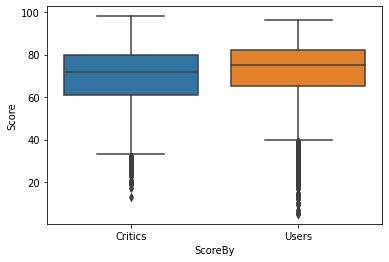

In [ ]:
sns.boxplot(x='ScoreBy', y='Score', data=scores)

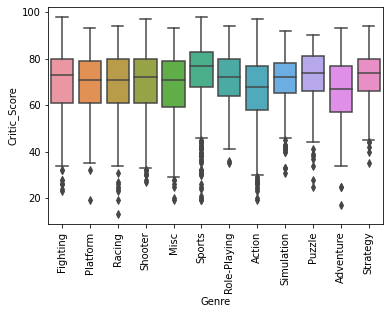

In [ ]:
sns.boxplot(x='Genre', y='Critic_Score', data=df)
plt.xticks(rotation=90)
plt.show()

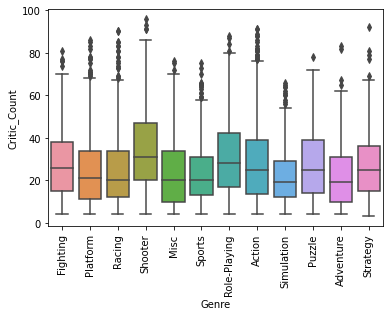

In [ ]:
sns.boxplot(x='Genre', y='Critic_Count', data=df)
plt.xticks(rotation=90)
plt.show()

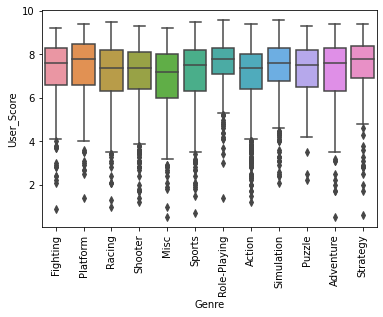

In [ ]:
sns.boxplot(x='Genre', y='User_Score', data=df)
plt.xticks(rotation=90)
plt.show()

#### 수치형 데이터간의 상관성 시각화

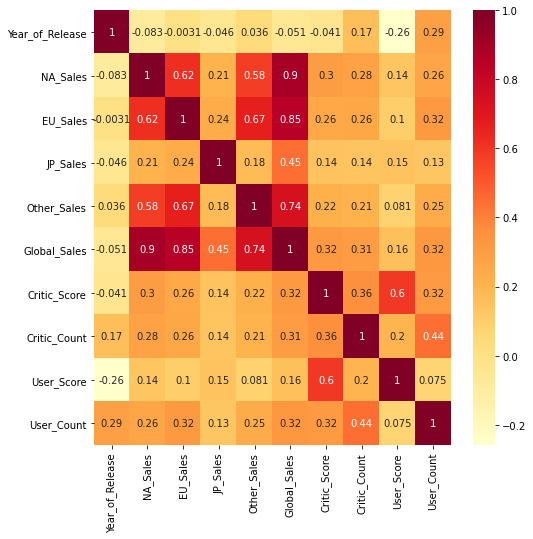

In [ ]:
fig = plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap='YlOrRd')

### Step 2. 모델 학습을 위한 전처리

#### 범주형 데이터에서 소수 범주를 others로 대체

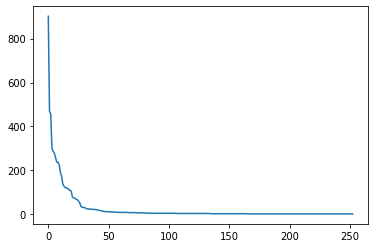

In [ ]:
pb = df['Publisher'].value_counts()
plt.plot(range(len(pb)), pb)

In [ ]:
df['Publisher'] = df['Publisher'].apply(lambda s: s if s not in pb[20:] else 'others')

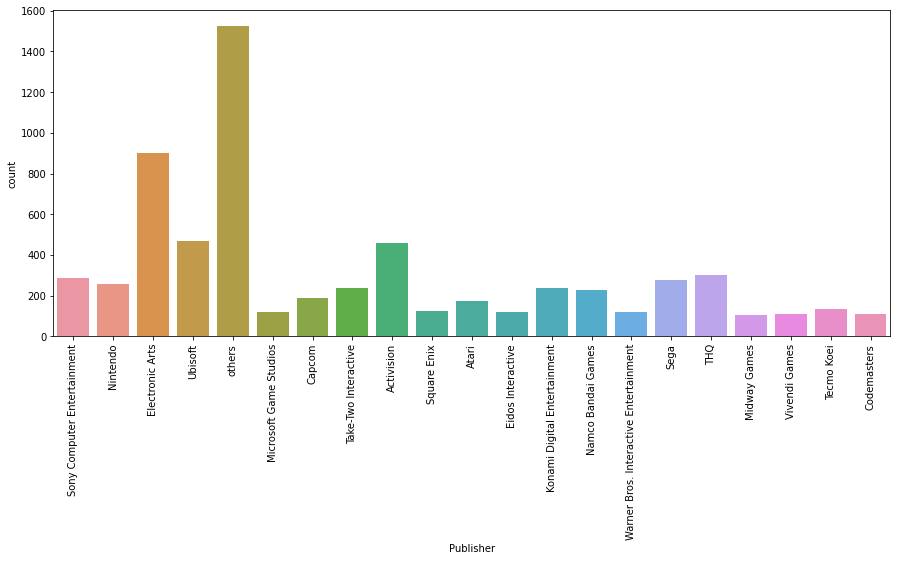

In [ ]:
fig = plt.figure(figsize=(15, 6))
sns.countplot(x='Publisher', data=df)
plt.xticks(rotation=90)
plt.show()

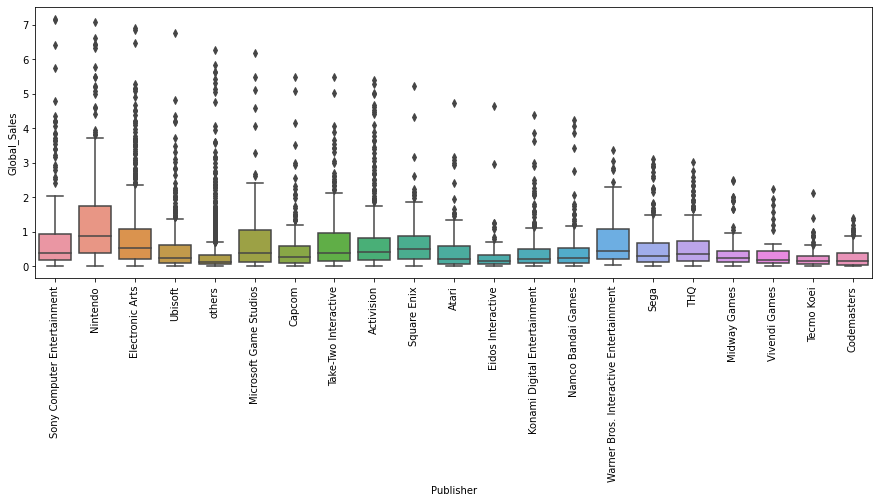

In [ ]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x='Publisher', y='Global_Sales', data=df)
plt.xticks(rotation=90)
plt.show()

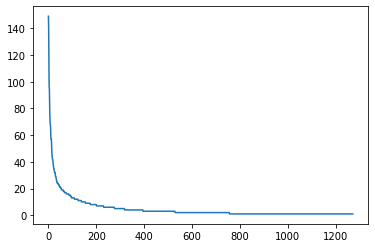

In [ ]:
dev = df['Developer'].value_counts()
plt.plot(range(len(dev)), dev)

In [ ]:
df['Developer'] = df['Developer'].apply(lambda s: s if s not in dev[20:] else 'others')

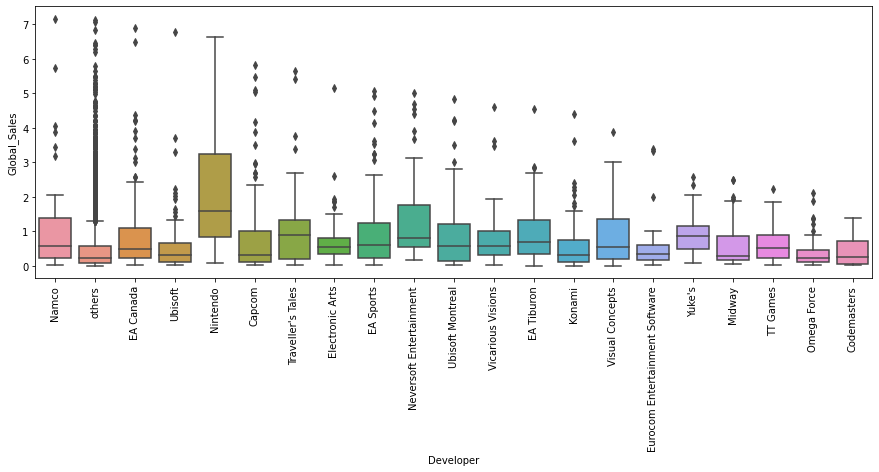

In [ ]:
fig = plt.figure(figsize=(15, 5))
sns.boxplot(x='Developer', y='Global_Sales', data=df)
plt.xticks(rotation=90)
plt.show()

#### get_dummies를 이용한 범주형 데이터 전처리

In [ ]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

In [ ]:
X_cat = df[['Platform', 'Genre', 'Publisher']]
X_cat = pd.get_dummies(X_cat, drop_first=True)

### Step 3. Regression 모델 학습하기(y : 회귀유형)

-  일반 모델로 Linear Regression 모델과 LGBM으로 분석

In [ ]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Developer', 'Rating'],
      dtype='object')

#### StandardScaler를 이용해 수치형 데이터 표준화

In [ ]:
X_num = df[['Year_of_Release', 'Critic_Score', 'Critic_Count']]
scaler = StandardScaler()
scaler.fit(X_num)
X_scaled = scaler.transform(X_num)
X_scaled = pd.DataFrame(X_scaled, index=X_num.index, columns=X_num.columns)

X = pd.concat([X_scaled, X_cat], axis=1)
y = df['Global_Sales']

In [ ]:
X.head()

,Year_of_Release,Critic_Score,Critic_Count,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,Platform_PS3,Platform_PS4,Platform_PSP,Platform_PSV,Platform_Wii,Platform_WiiU,Platform_X360,Platform_XB,Platform_XOne,Genre_Adventure,Genre_Fighting,Genre_Misc,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Publisher_Atari,Publisher_Capcom,Publisher_Codemasters,Publisher_Eidos Interactive,Publisher_Electronic Arts,Publisher_Konami Digital Entertainment,Publisher_Microsoft Game Studios,Publisher_Midway Games,Publisher_Namco Bandai Games,Publisher_Nintendo,Publisher_Sega,Publisher_Sony Computer Entertainment,Publisher_Square Enix,Publisher_THQ,Publisher_Take-Two Interactive,Publisher_Tecmo Koei,Publisher_Ubisoft,Publisher_Vivendi Games,Publisher_Warner Bros. Interactive Entertainment,Publisher_others
106,-2.237912,1.944152,-0.704478,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
109,-2.237912,1.577371,-0.874440,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
111,-1.514757,1.650727,0.598567,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
113,-0.791602,0.917163,0.655221,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
114,-1.273706,1.357302,0.088680,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### 학습데이터와 테스트데이터 분리하기

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
from sklearn.linear_model import LinearRegression as LR
from lightgbm import LGBMRegressor as LGBM_R
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

In [ ]:
X.isna().sum()

Year_of_Release                                     0
Critic_Score                                        0
Critic_Count                                        0
Platform_DC                                         0
Platform_DS                                         0
Platform_GBA                                        0
Platform_GC                                         0
Platform_PC                                         0
Platform_PS                                         0
Platform_PS2                                        0
Platform_PS3                                        0
Platform_PS4                                        0
Platform_PSP                                        0
Platform_PSV                                        0
Platform_Wii                                        0
Platform_WiiU                                       0
Platform_X360                                       0
Platform_XB                                         0
Platform_XOne               

In [ ]:
# LinearRegression 모델 생성/학습
model_lr = LR()
model_lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### 기본모델 학습 결과 평가하기

In [ ]:
pred = model_lr.predict(X_test)
print(MAE(y_test, pred))
print(sqrt(MSE(y_test, pred)))

0.4435623723861831
0.7033240396642875


#### 파라미터 그리드 설계_LGBM

In [ ]:
# 모델 파라미터 그리드 설계
# 키가 모델의 함수, 값이 파라미터 그리드의 값
param_grid = dict() 

param_grid_for_LGBM_R = ParameterGrid({"max_depth": [2, 3, 4,5],
                                      "n_estimators": [50, 100,150, 200],
                                      "learning_rate": [0.05, 0.1, 0.15, 0.2]})

param_grid[LGBM_R] = param_grid_for_LGBM_R


# 출력을 위한 max_iter_num 계산 
                            
# 튜닝 시작
best_score = 9999999999 
iteration_num = 0    
for k in range(30, 5, -1): 
    print(k)
  
    for model_func in [LGBM_R]:
        for param in param_grid[model_func]:
            model = model_func(**param).fit(X_train, y_train)
            y_pred = model.predict(X_test)
            score = MAE(y_test, y_pred)
            if score < best_score:
                best_model_func = model_func
                best_score = score
                best_parameter = param
            iteration_num += 1      


print("모델:", best_model_func)
print("점수:", best_score)
print("파라미터:", best_parameter)   

30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
모델: <class 'lightgbm.sklearn.LGBMRegressor'>
점수: 0.38427196922116585
파라미터: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


#### LGBM 학습 및 모델 평가

In [ ]:
final_model_lgbm = LGBM_R(max_depth=4, n_estimators=200,learning_rate=0.1)
final_model_lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=4,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
pred_LGBM = final_model_lgbm.predict(X_test)
print(MAE(y_test, pred_LGBM))
print(sqrt(MSE(y_test, pred_LGBM)))

0.38427196922116585
0.6637104832198417


#### 실제 값과 추측 값의 Scatter plot 시각화

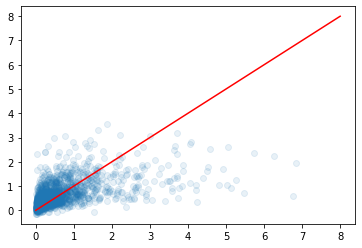

In [ ]:
plt.scatter(y_test, pred_LGBM, alpha=0.1)
plt.plot([0, 8], [0,8], 'r-')
# 많이 팔린 제품을 아웃라이어로 제거를 했기때문에 적게 팔린것만 예측하고 있음. 

#### LGBM 모델의 Feature Importance 시각화하기

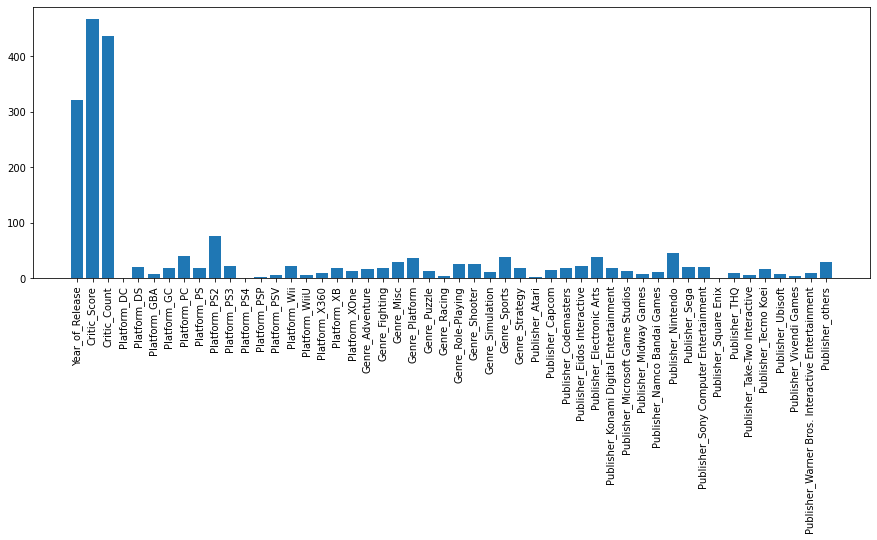

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.bar(X.columns, final_model_lgbm.feature_importances_)
plt.xticks(rotation=90)
plt.show()

### Step 5. 딥러닝.신경망 모델로 분석

In [ ]:
from keras.optimizers import Adam

In [ ]:
print(X_train.shape, y_train.shape)

(4540, 50) (4540,)


#### 모델구현

In [ ]:
    model = models.Sequential()
    model.add(layers.Dense(32, activation='relu',input_shape=(50,)))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(1))
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1632      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                5

In [ ]:
# 콜백 함수 적용 부분(분류모델은 val_loss로)
early_stopping_callback = EarlyStopping(monitor='loss', mode='min', patience=10)
# 분류모델이면 model_checkpoint = ModelCheckpoint(filepath='./{epoch}-{val_loss:.2f}-{val_accuracy:.2f}.h5', monitor='val_loss', save_best_only=True, verbose=1)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제9_딥러닝파라미터/{epoch}-{loss:.2f}.h5', 
                                   monitor='loss', save_best_only=True, verbose=1)


history = model.fit(X_train, y_train, batch_size=32,  epochs=1000,
            callbacks=[early_stopping_callback, model_checkpoint],
            validation_data=(X_test, y_test))

Epoch 1/1000
142/142 [==============================] - 3s 6ms/step - loss: 1.6583 - mae: 0.8888 - val_loss: 0.5784 - val_mae: 0.4240

Epoch 00001: loss improved from inf to 1.15344, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제9_딥러닝파라미터/1-1.15.h5
Epoch 2/1000
142/142 [==============================] - 1s 5ms/step - loss: 0.6610 - mae: 0.5365 - val_loss: 0.5339 - val_mae: 0.4197

Epoch 00002: loss improved from 1.15344 to 0.62709, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제9_딥러닝파라미터/2-0.63.h5
Epoch 3/1000
142/142 [==============================] - 1s 5ms/step - loss: 0.5661 - mae: 0.4887 - val_loss: 0.5206 - val_mae: 0.4467

Epoch 00003: loss improved from 0.62709 to 0.56476, saving model to /content/drive/MyDrive/Colab Notebooks/practice/분류문제/문제9_딥러닝파라미터/3-0.56.h5
Epoch 4/1000
142/142 [==============================] - 1s 5ms/step - loss: 0.5678 - mae: 0.4702 - val_loss: 0.5130 

In [ ]:
print(sqrt(0.2403))

0.49020403915104577


#### 딥러닝 모델평가

In [ ]:
model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 2ms/step - loss: 0.5899 - mae: 0.4254


[0.589932382106781, 0.42540451884269714]

In [ ]:
print(model.predict(X_test[5:10]))
print(y_test[5:10])

[[0.1935788 ]
 [0.33863634]
 [0.3054297 ]
 [0.33234692]
 [0.97994006]]
13221    0.05
395      3.39
8646     0.16
11547    0.08
3490     0.57
Name: Global_Sales, dtype: float64


In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

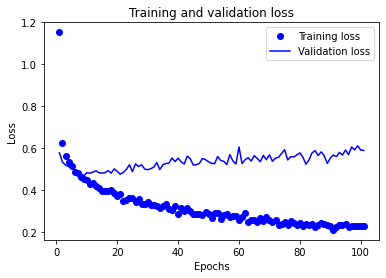

In [ ]:
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

# ‘bo’는 파란색 점을 의미합니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# ‘b’는 파란색 실선을 의미합니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

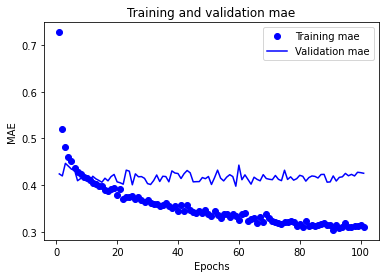

In [ ]:
plt.clf()   # 그래프를 초기화합니다
mae = history.history['mae'] 
val_mae = history.history['val_mae'] 

plt.plot(epochs, mae, 'bo', label='Training mae')
plt.plot(epochs, val_mae, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.show()